In [4]:
%matplotlib inline

Automatically created module for IPython interactive environment


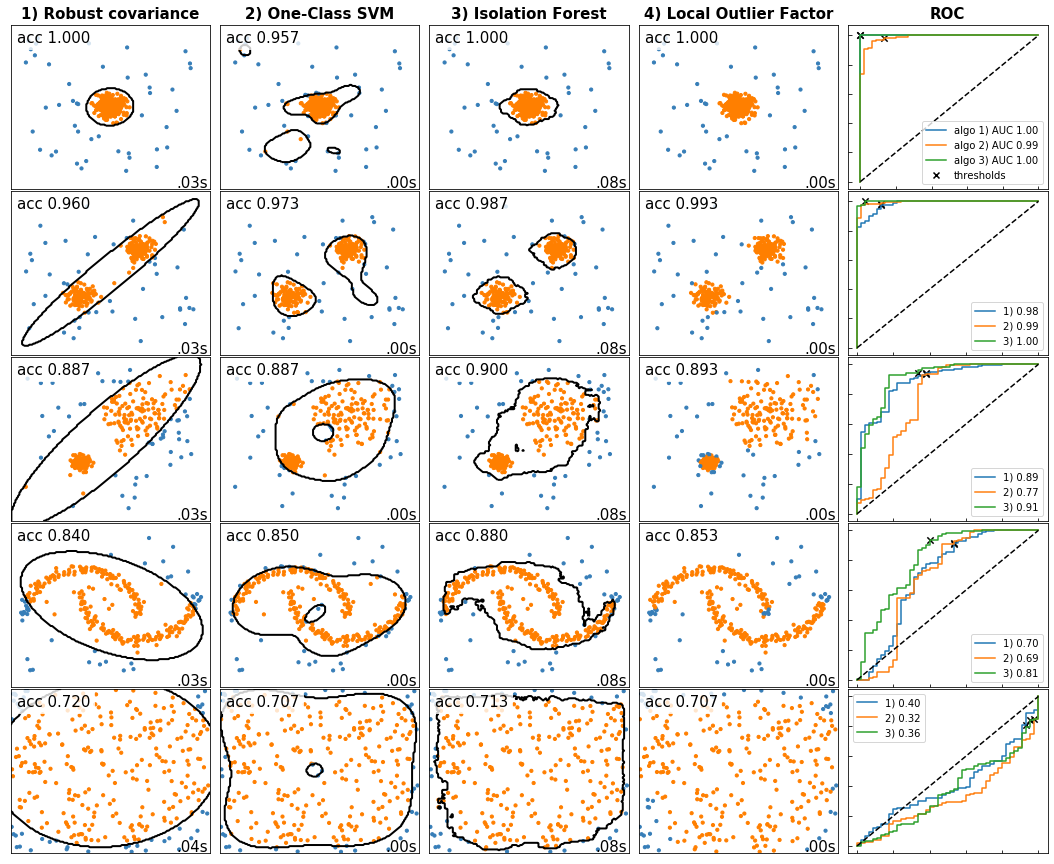

In [29]:
"""
============================================================================
Comparing anomaly detection algorithms for outlier detection on toy datasets
============================================================================

This example shows characteristics and compares the performance of different 
anomaly detection algorithms on 2D datasets. Datasets contain one or two 
modes (region of high density) to illustrate the ability of algorithm to 
cope with multimodel data.

Algorithms:
- Robust covariance, `sklearn.covariance.EllipticEnvelope`
- One-Class SVM, `sklearn.svm.OneClassSVM`
- Isolation Forest, `sklearn.ensemble.IsolationForest`
- Local Outlier Factor (LOF), `sklearn.neighbors.LocalOutlierFactor`

Here are the update in this example:
- Add the quatitative parameters to compare the algorithms performance
    - `accuracy_score`: to measure the anomaly detection ability
    - `roc_curve`: to visualize the operating characteristic (ROC) curve 
    (tpr vs. fpr)
    - `roc_auc_score`: to calculate the area under ROC curve
    
Note: 
Only the algorithm that has `decision_function` can compute `roc_curve`
and `roc_auc_score`. Thus, we still lack important parameters to compare the 
Local outlier factor against other algorithms.

Result and disscussion:
The figures show the outlier detection performance and visualization. 
Each row represents different datasets. The first four columns compare each
algorithm the computation time (``.__ s``) and outlier prediction accuracy 
(``acc``). The number and name of each outlier detection algorithm are on 
the top of the column. The last column plots all four algorithms in 
the ROC curve compare AUC score. The number label on AUC score matches the 
number in front of the algorithm names. The ``x`` sign in the ROC curves 
indicate the thresholds where algorithms start to classify data as outliers.

From the plots, ``sklearn.covariance.EllipticEnvelope`` shows best result 
in high dimensional noise ``d_noise = 10``. However, since robust 
covariance creates a ellptical envelope for inliers, we need more test 
on an inlier data that is not in a elliptical shape.

"""

import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

print(__doc__)

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
                                      gamma="scale")),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction,
                                         behaviour = "new", random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(
        n_neighbors=35, contamination=outliers_fraction))]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3],
               **blobs_params)[0],
    4. * (make_moons(n_samples=n_inliers, noise=.05, random_state=0)[0] -
          np.array([0.5, 0.25])),
    14. * (np.random.RandomState(42).rand(n_inliers, 2) - 0.5)]

# label the ground truth
y_true = np.concatenate([np.ones(n_inliers), -np.ones(n_outliers)], axis=0)

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150),
                     np.linspace(-7, 7, 150))

plt.figure(figsize=((len(anomaly_algorithms)+1) * 2.2+1 + 3, len(datasets)*2.2+1))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    X = np.concatenate([X, rng.uniform(low=-6, high=6,
                       size=(n_outliers, 2))], axis=0)
    
    # list of AUC and ROC
    list_AUC = []
    list_fpr = []
    list_tpr = []
    list_thresh = []
    
    algo_index = 0
    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        
        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)
            
            # store ROC plot 
            probas_ = algorithm.fit(X).decision_function(X) 
            ## LOF does not implement decision_function
            AUC = roc_auc_score(y_true, probas_) # AUC
            fpr, tpr, thresholds = roc_curve(y_true, probas_)
            thresh_index = np.where(abs(thresholds) == min(abs(thresholds)))[0][0]
            list_AUC.append(AUC)
            list_fpr.append(fpr)
            list_tpr.append(tpr)
            list_thresh.append(thresh_index)   
        
        acc = accuracy_score(y_true, y_pred) # acuracy
        plt.subplot(len(datasets), len(anomaly_algorithms)+1, plot_num)
        if i_dataset == 0:
            plt.title(str(algo_index + 1) + ") " + name, size=15, weight="bold")

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        
        # show prediction accuracy
        bbox_props = dict(boxstyle="square", fc="white", ec="none", alpha =0.8)
        plt.text(.03, .89, ("acc %.3f" % acc).lstrip("0"),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment="left", bbox = bbox_props)        
        plot_num += 1
        algo_index += 1
        
    # plot the ROC curves and show AUC scores
    plt.subplot(len(datasets), len(anomaly_algorithms) + 1, plot_num)

    if i_dataset == 0:
        plt.title("ROC", size=15, color="black", weight="bold")
        
        # lebel the decision_function's thresholds
        plt.scatter([], [], marker="x", color="black", label="thresholds")
        
    for algo_index in range(len(anomaly_algorithms)-1): # exclude LOF
        
        if i_dataset == 0:
            plt.plot(list_fpr[algo_index], list_tpr[algo_index],
                label="algo " + str(algo_index + 1)+ ")"
                + (" AUC %.2f" % list_AUC[algo_index]).lstrip("0"))
        else:
            plt.plot(list_fpr[algo_index], list_tpr[algo_index],
                label= str(algo_index + 1)+ ")"
                + (" %.2f" % list_AUC[algo_index]).lstrip("0"))
        
        plt.scatter(
        list_fpr[algo_index][list_thresh[algo_index]],
        list_tpr[algo_index][list_thresh[algo_index]],
        s=40, marker="x", color = 'black')
            
    plt.plot(np.array([0, 1]), np.array([0, 1]), linestyle="--", color="black")
    plt.legend()
    plt.tick_params(labelleft = False, labelbottom = False, direction  = "in")
    plot_num += 1          
            
plt.show()